# Benders decomposition using Julia

In [1]:
using JuMP, GLPK, OSQP

In [2]:
using Printf, Plots

In [3]:
## Parameters
# costs
cS1 = [10,20]
cS2 = [20,80]

# scenario probability
pi_w = [0.25,0.25,0.25,0.25]

# uncertain parameter
theta = [30,60,70,10]

# bound
alpha_down = -6000;

In [4]:
## Modeling the master problem  --> checking the problem use> print(master)
#master = Model(OSQP.Optimizer)
master = Model(GLPK.Optimizer)
set_silent(master)

@variable(master, 0 ≤ p_da_g1 ≤ 100, start = 90)
@variable(master, 0 ≤ p_da_g2 ≤ 30, start = 30)
@variable(master, 0 ≤ p_da_w ≤ 70, start = 0)
@variable(master, α ≥ alpha_down)

@constraint(master, p_da_g1 + p_da_g2 + p_da_w == 120)

@objective(master, Min, cS1[1]*p_da_g1 + cS1[2]*p_da_g2 + α);

In [5]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(u_fixed,theta_unc,prob_s)
    # building subproblem model
    #sub = Model(OSQP.Optimizer)
    sub = Model(GLPK.Optimizer)
    set_silent(sub)
    
    # same variables as master problem 
    @variable(sub,p_da_g1)
    @variable(sub,p_da_g2)
    @variable(sub,p_da_w)
    # subproblem (exclusive) variables
    @variable(sub, -30 ≤ p_rt_g2 ≤ 30)
    @variable(sub, 0 ≤ p_w_spill ≤ theta_unc)
    @variable(sub, 0 ≤ p_curtail ≤ 120)
    
    @constraint(sub, 0 ≤ p_da_g2 + p_rt_g2 ≤ 30)
    @constraint(sub, p_rt_g2 + (theta_unc -  p_da_w - p_w_spill) + p_curtail == 0)
    
    @constraint(sub, p_da_g1 - u_fixed[1] == 0)
    @constraint(sub, p_da_g2 - u_fixed[2] == 0)
    @constraint(sub, p_da_w - u_fixed[3] == 0)
    
    @objective(sub, Min, prob_s*(cS2[1]*p_rt_g2 + cS2[2]*p_curtail))
    #print(sub)
    #@show sub
    
    optimize!(sub)
    #a = termination_status(sub)
    
    #calling values of the solved subproblem
    o = objective_value(sub)
    r = value(p_rt_g2)
    s = value(p_w_spill)
    c = value(p_curtail)
    all_con = all_constraints(sub, AffExpr, MOI.EqualTo{Float64})
    #print(all_con)
    λ = dual.(all_con)
    
    return Dict('o' => o, 'λ' => λ, 'r' => r, 's' => s, 'c' => c)
end


subp (generic function with 1 method)

In [6]:
#subp([90,30,0],10,0.25)

In [7]:
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end

print_iteration (generic function with 1 method)

In [8]:
println("k  p_da_g1  p_da_g2  p_da_w   lowerbound    upperbound  gap")

p = plot(legend=false, xlabel="iteration", ylabel="OF value")

for k in 1:100
    # solve master problem
    optimize!(master)
    
    # lower bound of the original problem
    lb = objective_value(master)
    p_da_g1ᵏ = value(p_da_g1)
    p_da_g2ᵏ = value(p_da_g2)
    p_da_wᵏ = value(p_da_w)
    
    # solve the subproblem to find the upper 
    ub = cS1[1]*p_da_g1ᵏ + cS1[2]*p_da_g2ᵏ + sum(subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[ii],pi_w[ii])['o'] for ii in 1:4)
    
    # compute optimality gap
    gap = abs(ub - lb)/abs(ub)
    
    # print iteration information
    print_iteration(k,p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ,lb,ub,gap)

    plot!([k],[lb], marker=:circle,  markercolor = :green)
    plot!([k],[ub], marker=:square, markercolor = :red)
    
    # check if optimality gap is small enough
    if gap < 1e-5 || k == 100
        println(" **** solution found ********")
        println("s  p_rt_g2  p_spill  p_curt")
        for wi in 1:4
            rt = subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[wi],pi_w[wi])['r']
            spill = subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[wi],pi_w[wi])['s']
            curt = subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[wi],pi_w[wi])['c']
            print_iteration(wi,rt,spill,curt)
        end
        
        break
    end
    
    # sensitivity (num scenario, num var)
    lambda_M = [subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[wi],pi_w[wi])['λ'] for wi in 1:4]    
    benderscut = @constraint(master, α ≥  sum(subp([p_da_g1ᵏ,p_da_g2ᵏ,p_da_wᵏ],theta[ii],pi_w[ii])['o'] for ii in 1:4) + sum(lambda_M[ii][3] for ii in 1:4)*(p_da_g2 - p_da_g2ᵏ) + sum(lambda_M[ii][4] for ii in 1:4)*(p_da_w - p_da_wᵏ))
    #@info "Adding this bender cut $(benderscut)"
end

k  p_da_g1  p_da_g2  p_da_w   lowerbound    upperbound  gap
        1   5.0000e+01   0.0000e+00   7.0000e+01  -5.5000e+03   1.6500e+03   4.3333e+00
        2   1.0000e+02   2.0000e+01   0.0000e+00  -3.5000e+02   1.0500e+03   1.3333e+00
        3   6.8889e+01   3.0000e+01   2.1111e+01   8.9444e+02   1.1667e+03   2.3333e-01
        4   6.8889e+01   2.7778e+00   4.8333e+01   8.9444e+02   1.1667e+03   2.3333e-01
        5   8.2500e+01   3.0000e+01   7.5000e+00   9.6250e+02   1.0000e+03   3.7500e-02
        6   8.2500e+01   2.6250e+01   1.1250e+01   9.6250e+02   1.0000e+03   3.7500e-02
        7   8.0000e+01   3.0000e+01   1.0000e+01   1.0000e+03   1.0000e+03   0.0000e+00
 **** solution found ********
s  p_rt_g2  p_spill  p_curt
        1  -2.0000e+01   0.0000e+00   0.0000e+00
        2  -3.0000e+01   2.0000e+01   0.0000e+00
        3  -3.0000e+01   3.0000e+01   0.0000e+00
        4   0.0000e+00   0.0000e+00   0.0000e+00


In [9]:
#print(master)

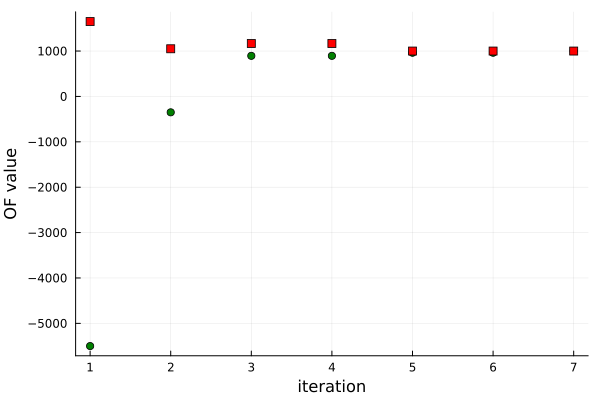

In [10]:
display(p)